<a href="https://colab.research.google.com/github/atick-faisal/Crowd-Emotion/blob/main/src_v4/CE_TE_YAMNET_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow_io

In [2]:
import os
import time
import json
import datetime

import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

from sklearn.metrics import classification_report

In [3]:
CONFIG = {
    'timestamp'             : str(datetime.datetime.now()),
    'test_fold'             : 'Fold 1',
    'architecture'          : '',
    'batch_size'            : 32,
    'epochs'                : 0,
    'learning_rate'         : 0.00001,
    'patience'              : 2,
    'training_time'         : 0,
    'testing_time'          : 0,
    'confusion_matrix'      : '',
    'classification_report' : ''
}

In [4]:
FOLDS = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
EMOTIONS = ['Approval', 'Disapproval', 'Neutral']

In [5]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [6]:
# %%time
# !mkdir /content/Dataset
# !gdown --id '1HOe5sJe_Juf5uib4f-8pPv-Z64lmqQ4X'
# !tar -xf /content/Crowd-Emotion-Dataset.tar.xz -C /content/Dataset/

In [25]:
# %%time
# !cp -R '/content/drive/MyDrive/Research/Crowd Emotion Val/Normalized' /content/

In [7]:
@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [8]:
%%time
filenames = []
labels = []
folds = []
dataset_path = '/content/Dataset/'
for emotion in EMOTIONS:
    print('processing files for ' + emotion, end=' ... ')
    for fold in FOLDS:
        files_path = os.path.join(dataset_path, emotion, fold)
        for filename in os.listdir(files_path):
            filenames.append(os.path.join(files_path, filename))
            labels.append(EMOTIONS.index(emotion))
            folds.append(FOLDS.index(fold))
    print('√')

processing files for Approval ... √
processing files for Disapproval ... √
processing files for Neutral ... √
CPU times: user 4.57 ms, sys: 1.99 ms, total: 6.56 ms
Wall time: 5.58 ms


In [9]:
main_ds = tf.data.Dataset.from_tensor_slices((filenames, labels, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [28]:
%%time
filenames = []
labels = []
folds = []
dataset_path = '/content/Normalized/'
for emotion in EMOTIONS:
    print('processing files for ' + emotion, end=' ... ')
    files_path = os.path.join(dataset_path, emotion)
    for filename in os.listdir(files_path):
        filenames.append(os.path.join(files_path, filename))
        labels.append(EMOTIONS.index(emotion))
        folds.append(FOLDS.index(fold))
    print('√')

processing files for Approval ... √
processing files for Disapproval ... √
processing files for Neutral ... √
CPU times: user 2.73 ms, sys: 2.1 ms, total: 4.83 ms
Wall time: 3.79 ms


In [29]:
test_ds = tf.data.Dataset.from_tensor_slices((filenames, labels, folds))
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [10]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [30]:
test_ds = test_ds.map(load_wav_for_map)
test_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [11]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [31]:
test_ds = test_ds.map(extract_embedding).unbatch()
test_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [32]:
cached_ds = main_ds.cache()
cached_ds_test = test_ds.cache()
train_ds = cached_ds.filter(
    lambda embedding, label, fold: fold != FOLDS.index(CONFIG['test_fold'])
)
val_ds = cached_ds.filter(
    lambda embedding, label, fold: fold == FOLDS.index(CONFIG['test_fold'])
)
test_ds = cached_ds_test

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)

In [13]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(EMOTIONS))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 526,339
Trainable params: 526,339
Non-trainable params: 0
_________________________________________________________________


In [14]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=CONFIG['patience'],
                                            restore_best_weights=True)

In [15]:
%%time
start_time = time.time()
history = my_model.fit(train_ds,
                       epochs=300,
                       validation_data=val_ds,
                       callbacks=callback)
training_time = time.time() - start_time

Epoch 1/300
202/202 [==============================] - 87s 339ms/step - loss: 0.9338 - accuracy: 0.6595 - val_loss: 1.0105 - val_accuracy: 0.5019
Epoch 2/300
202/202 [==============================] - 1s 5ms/step - loss: 0.8887 - accuracy: 0.6553 - val_loss: 0.9630 - val_accuracy: 0.5875
Epoch 3/300
202/202 [==============================] - 1s 5ms/step - loss: 0.8636 - accuracy: 0.6263 - val_loss: 0.9273 - val_accuracy: 0.6362
Epoch 4/300
202/202 [==============================] - 1s 6ms/step - loss: 0.8265 - accuracy: 0.6414 - val_loss: 0.8973 - val_accuracy: 0.6743
Epoch 5/300
202/202 [==============================] - 1s 6ms/step - loss: 0.7962 - accuracy: 0.6463 - val_loss: 0.8705 - val_accuracy: 0.6958
Epoch 6/300
202/202 [==============================] - 1s 5ms/step - loss: 0.7681 - accuracy: 0.6690 - val_loss: 0.8472 - val_accuracy: 0.7034
Epoch 7/300
202/202 [==============================] - 1s 6ms/step - loss: 0.7413 - accuracy: 0.6797 - val_loss: 0.8268 - val_accuracy: 0.7

In [33]:
%%time

start_time = time.time()

loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

testing_time = time.time() - start_time

157/157 [==============================] - 49s 309ms/step - loss: 0.6640 - accuracy: 0.7119
Loss:  0.6639807820320129
Accuracy:  0.7119251489639282
CPU times: user 49 s, sys: 1.97 s, total: 51 s
Wall time: 49.5 s


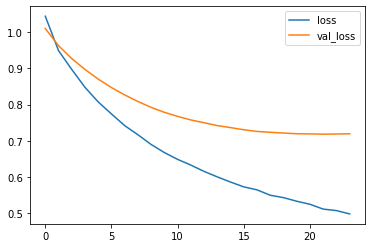

In [17]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [18]:
test_labels = []
for _, label in test_ds:
    test_labels += (label.numpy().tolist())
y_true = np.squeeze(np.array(test_labels))

In [19]:
y_pred = np.argmax(my_model.predict(test_ds), axis=1)

In [20]:
result = classification_report(y_true, y_pred)
print(result)

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       731
           1       0.73      0.44      0.55       226
           2       0.68      0.71      0.70       621

    accuracy                           0.70      1578
   macro avg       0.70      0.64      0.66      1578
weighted avg       0.70      0.70      0.69      1578



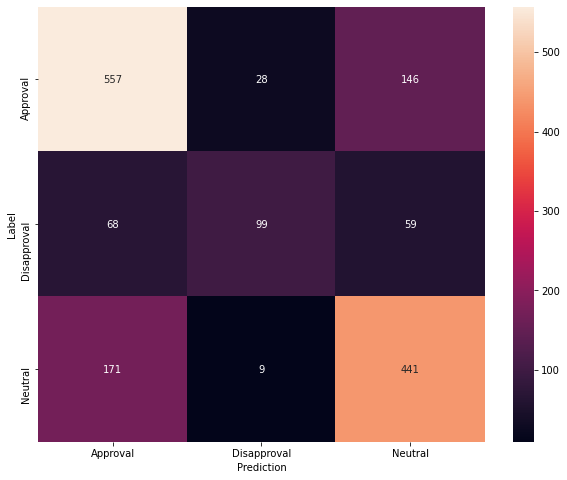

In [21]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=EMOTIONS, yticklabels=EMOTIONS, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [22]:
summary = []
my_model.summary(print_fn=lambda x: summary.append(x))
CONFIG['architecture'] = summary
CONFIG['epochs'] = max(history.epoch)
CONFIG['training_time'] = training_time
CONFIG['testing_time'] = testing_time
CONFIG['confusion_matrix'] = np.array2string(confusion_mtx.numpy())
result_list = result.split('\n')
CONFIG['classification_report'] = result_list

In [23]:
config = json.dumps(CONFIG, indent=4)
print(config)

{
    "timestamp": "2021-05-07 16:46:32.123151",
    "test_fold": "Fold 1",
    "architecture": [
        "Model: \"my_model\"",
        "_________________________________________________________________",
        "Layer (type)                 Output Shape              Param #   ",
        "=================================================================",
        "dense (Dense)                (None, 512)               524800    ",
        "_________________________________________________________________",
        "dropout (Dropout)            (None, 512)               0         ",
        "_________________________________________________________________",
        "dense_1 (Dense)              (None, 3)                 1539      ",
        "=================================================================",
        "Total params: 526,339",
        "Trainable params: 526,339",
        "Non-trainable params: 0",
        "________________________________________________________________